# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from matplotlib.path    import Path
from matplotlib.patches import PathPatch

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

# Define time grids.

Change these parameters:

In [4]:
time_travel_ivt_to_mt = 60
time_travel_max       = 240

grid_step = 1 

## Travel time to the IVT centre:

In [5]:
# Times for each row....
grid_x_times = (
    np.arange(-time_travel_max, time_travel_max+grid_step, grid_step))
# ... and each column.
grid_y_times = np.copy(grid_x_times)

# Mesh to create new grids by stacking the rows (grid_xx)
# and the columns (grid_yy):
grid_xx, grid_yy = np.meshgrid(grid_x_times, grid_y_times)

# Then combine the two temporary grids to find distances: 
grid_time_travel_directly_to_ivt = np.sqrt(grid_xx**2.0 + grid_yy**2.0)

## Travel time directly to the MT centre:

In [6]:
# Times for each row....
grid_x_times = (
    np.arange(-time_travel_max, time_travel_max+grid_step, grid_step))
# ... and each column.
grid_y_times = np.copy(grid_x_times) + time_travel_ivt_to_mt

# Mesh to create new grids by stacking the rows (grid_xx)
# and the columns (grid_yy):
grid_xx, grid_yy = np.meshgrid(grid_x_times, grid_y_times)

# Then combine the two temporary grids to find distances: 
grid_time_travel_directly_to_mt = np.sqrt(grid_xx**2.0 + grid_yy**2.0)

## Plot the grids

In [7]:
extent = [-time_travel_max - grid_step*0.5, 
          +time_travel_max - grid_step*0.5, 
          -time_travel_max - grid_step*0.5, 
          +time_travel_max - grid_step*0.5] 

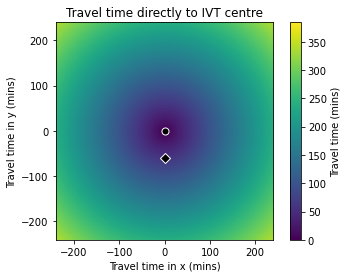

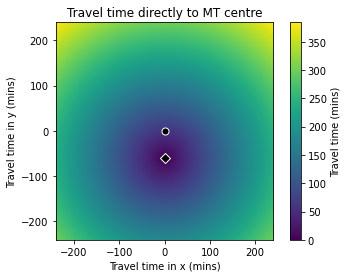

In [8]:
vmin = 0
vmax = np.max([grid_time_travel_directly_to_ivt,
               grid_time_travel_directly_to_mt])

for i in [0,1]:
    if i==0:
        plt.imshow(grid_time_travel_directly_to_ivt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to IVT centre')
    elif i==1:
        plt.imshow(grid_time_travel_directly_to_mt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to MT centre')
                
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')
    plt.show()

### Compare the two direct-travel grids:

In [9]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

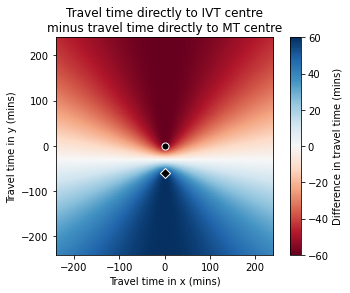

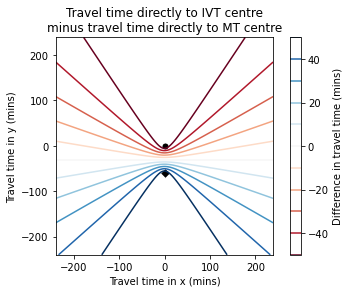

In [10]:
for i in [0,1]:
    if i==0:
        plt.imshow(grid_time_travel_directly_diff, origin='lower', extent=extent,
                   cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
    elif i==1:
        plt.contour(grid_time_travel_directly_diff, origin='lower', extent=extent,
                    levels=np.arange(-50,60,10), cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.title('Travel time directly to IVT centre'+'\n'+
              'minus travel time directly to MT centre')
    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')

    plt.gca().set_aspect('equal')
    plt.show()

There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

__Presumably these curves match the ones drawn in the Holodinsky et al. 2017 paper.__

## Travel time to MT centre via IVT centre

In [11]:
grid_time_travel_to_ivt_then_mt = (
    grid_time_travel_directly_to_ivt + time_travel_ivt_to_mt)

Text(0, 0.5, 'Travel time in y (mins)')

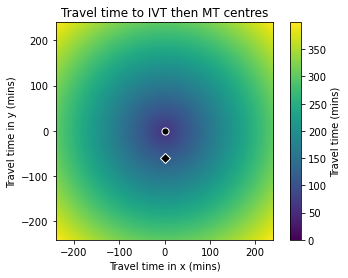

In [12]:
plt.imshow(grid_time_travel_to_ivt_then_mt, origin='lower', 
           extent=extent, vmin=0)
plt.colorbar(label='Travel time (mins)')

# Mark the treatment centre locations:
plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
            color='k', edgecolor='w', s=50)

plt.title('Travel time to IVT then MT centres')
plt.xlabel('Travel time in x (mins)')
plt.ylabel('Travel time in y (mins)')

### Compare travel to MT centre directly and via IVT centre:

In [13]:
grid_time_travel_to_mt_diff = (
    grid_time_travel_to_ivt_then_mt - grid_time_travel_directly_to_mt)

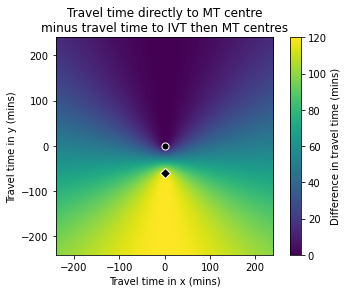

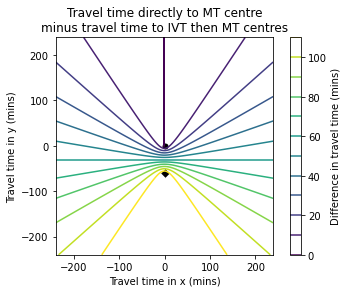

In [14]:
for i in [0,1]:
    if i==0:
        plt.imshow(grid_time_travel_to_mt_diff, origin='lower', extent=extent,
                   cmap='viridis')
        plt.colorbar(label='Difference in travel time (mins)')
    elif i==1:
        plt.contour(grid_time_travel_to_mt_diff, origin='lower', extent=extent,
                levels=np.arange(0, 2.0*time_travel_ivt_to_mt,10), 
                    cmap='viridis')
        plt.colorbar(label='Difference in travel time (mins)')
        
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.title('Travel time directly to MT centre'+'\n'+
              'minus travel time to IVT then MT centres')
    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')


    plt.gca().set_aspect('equal')
    plt.show()

# Example patient

### Travel to IVT centre then MT centre

Define some new parameters for extra time:

In [15]:
time_ivt_arrival_to_treatment = 10
time_ivt_treatment_to_travel  = 20 
time_mt_arrival_to_treatment  = 10

# Gather these into a list:
extra_times = [time_ivt_arrival_to_treatment, 
               time_ivt_treatment_to_travel, 
               time_mt_arrival_to_treatment]

# (might be better off with a dictionary of all times in this notebook) 

Make a new time grid for a patient who travels to an IVT centre and then an MT centre for treatment and has the given waiting times. 

In [16]:
grid_time_patient1 = np.copy(grid_time_travel_to_ivt_then_mt)
for extra_time in extra_times:
    grid_time_patient1 += extra_time 

### Travel directly to MT centre

In [17]:
grid_time_patient1a = np.copy(grid_time_travel_directly_to_mt)

grid_time_patient1a += time_mt_arrival_to_treatment

### Plot the time to onset of MT for this patient: 

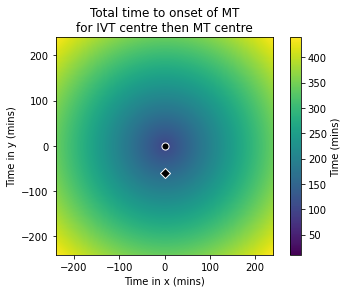

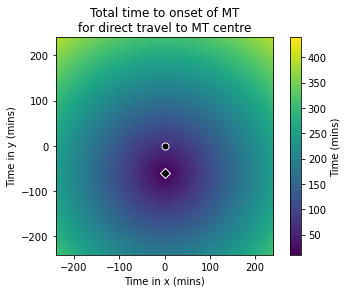

In [18]:
vmin = np.min([grid_time_patient1,
               grid_time_patient1a])
vmax = np.max([grid_time_patient1,
               grid_time_patient1a])

for i in [0,1]:
    if i==0:
        plt.imshow(grid_time_patient1, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax)
        plt.title('Total time to onset of MT'+'\n'+
                  'for IVT centre then MT centre')
    elif i==1:
        plt.imshow(grid_time_patient1a, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax)
        plt.title('Total time to onset of MT'+'\n'+
                  'for direct travel to MT centre')
    
    plt.colorbar(label='Time (mins)')

    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Time in x (mins)')
    plt.ylabel('Time in y (mins)')

    plt.show()

### Difference plot

In [19]:
grid_time_patient1_diff = (
    grid_time_patient1 - grid_time_patient1a)

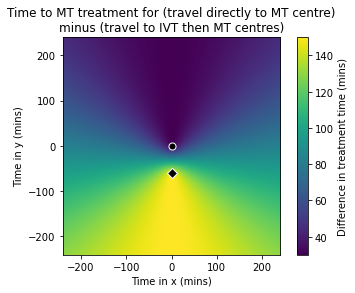

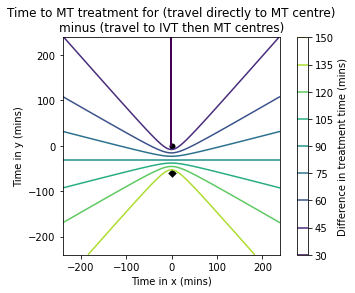

In [20]:
for i in [0,1]:
    if i==0:
        plt.imshow(grid_time_patient1_diff, origin='lower', extent=extent,
                   cmap='viridis')
    elif i==1:
        plt.contour(grid_time_patient1_diff, origin='lower', extent=extent,
            # levels=np.arange(-2.0*time_travel_ivt_to_mt,0,10), 
            cmap='viridis')
        
    plt.colorbar(label='Difference in treatment time (mins)')

    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.title('Time to MT treatment for (travel directly to MT centre)'+'\n'+
              'minus (travel to IVT then MT centres)')
    plt.xlabel('Time in x (mins)')
    plt.ylabel('Time in y (mins)')

    plt.gca().set_aspect('equal')
    plt.show()

# Travel time plot

Update plotting style:

In [79]:
time_step_circle = 15
circ_linewidth = 0.5
grid_cmap = 'viridis' 

In [80]:
def make_coords_truncated_circle(time_travel_max, time_travel_ivt_to_mt, 
                                 trunc_val=None, n_coords=360):
    # Find the point halfway between the treatment centres:
    y_halfway = -0.5*time_travel_ivt_to_mt
    if trunc_val == None:
        trunc_val = y_halfway
    
    # Make a normal circle...
    angles_circle = np.linspace(0,2.0*np.pi,n_coords)
    x_circ = time_travel_max * np.sin(angles_circle)
    y_circ = time_travel_max * np.cos(angles_circle)
    # ... then cut it off at the halfway point between the treatment 
    # centres:
    y_circ[np.where(y_circ < y_halfway)] = trunc_val 

    return x_circ, y_circ

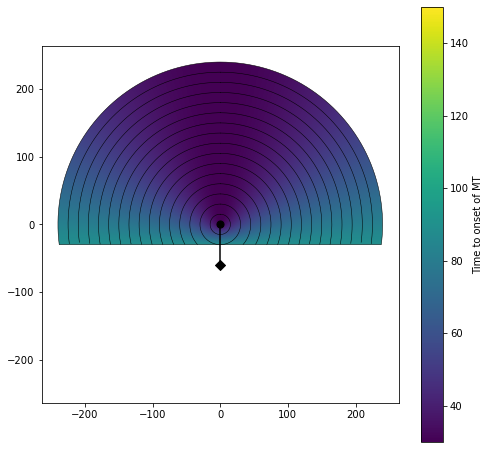

In [81]:
fig, ax = plt.subplots(figsize=(8,8))

# ----- Treatment centres ----- 
# Mark the treatment centre locations:
ax.scatter(0,0, marker='o', color='k', s=50)
ax.scatter(0,-time_travel_ivt_to_mt, marker='D', color='k', s=50)
# And draw a connecting line:
ax.plot([0,0], [0,-time_travel_ivt_to_mt], color='k')


# ----- Radiating circles ----- 
# Define times for the radiating circles:
circle_times = np.arange(
    time_step_circle, time_travel_max + time_step_circle, time_step_circle)

# Define coordinates and plot the radiating circles:
for travel_time in circle_times:
    if travel_time<time_travel_max:
        # Don't show the flat bottom line (gets thickened) 
        trunc_val = np.NaN
    else:
        # Show the flat bottom line 
        trunc_val = None
    # Define coordinates of the travel time circle.
    x_circ, y_circ = make_coords_truncated_circle(
        travel_time, time_travel_ivt_to_mt, trunc_val=trunc_val)

    if travel_time<time_travel_max:
        ax.plot(x_circ, y_circ, color='k', linewidth=circ_linewidth)
    else:
        # Make a patch using these coordinates. 
        # Use np.stack to get a series of ((x,y), (x,y), ... (x,y)) coords.
        circle_path  = Path(np.stack((x_circ,y_circ),axis=1))
        circle_patch = PathPatch(circle_path, 
                                 edgecolor='k', facecolor='None',
                                 linewidth = circ_linewidth)
        # Draw the patch:
        ax.add_patch(circle_patch)


# ----- Grid of times ----- 
# Draw the grid as usual:
imshow_grid = ax.imshow(grid_time_patient1_diff, origin='lower', 
                        extent=extent, cmap='viridis')
# Remove everything outside the biggest radiating circle:
imshow_grid.set_clip_path(circle_patch)
# Colourbar:
plt.colorbar(imshow_grid, ax=ax, label='Time to onset of MT')


# ----- Other setup -----
ax.set_aspect('equal')
ax.set_xlim(-time_travel_max*1.1, time_travel_max*1.1)
ax.set_ylim(-time_travel_max*1.1, time_travel_max*1.1)
plt.show()


__To do__ - colour bar still covers the full imshow grid, should change to remove the bit removed with flat circle bottom. 

# Convert time grid to mRS grid

Use the probability distributions for LVO and MT. Copied from datasets_full:

In [24]:
mrs_prob_bins_t0_treatment = np.array([0.3141, 0.4363, 0.5544, 0.7123, 0.8536, 0.9167, 1.    ])
mrs_prob_bins_no_treatment = np.array([0.0478, 0.1233, 0.2532, 0.41  , 0.646 , 0.775 , 1.    ])
t_ne = 8*60 # minutes

### From the maths notebook:

$$ P = \frac{1}{1+e^{-b\left(t +\frac{A}{b}\right)}} $$

$$ A =  \log\bigl[O(\mathrm{mRS}\leq x\ |\ t=0)\bigr] $$

So **$A$ is equal to the log-odds at $t=0\,$hr**.

$$ b = -\frac{a}{t_{\mathrm{ne}}} $$

$$ \log(OR) = a + bt $$

**$a$ is log(odds ratio) at t=0**, and **$b$ is the gradient of the slope**. 

### From the predict notebook:

In [25]:
from outcome_utilities.probs_with_time import find_mrs_constants

In [26]:
a, b, A = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                             mrs_prob_bins_no_treatment, t_ne)

In [27]:
print(a)
print(b)
print(A)

[2.21072902 1.70535233 1.30008248 1.27054628 1.16161751 1.16156909]
[-0.00460569 -0.00355282 -0.00270851 -0.00264697 -0.00242004 -0.00241994]
[-0.78102044 -0.25619211  0.21846476  0.9065809   1.7631201   2.39833172]


## Example patient

Make some more assumptions about our patient:

In [92]:
# Equivalent to patient 'x':
prob_start = 0.345

In [93]:
grids_probs = []

for mrs in range(6):
    grid_probs = 1.0 / (1.0 + np.exp(-b[mrs]*(grid_time_patient1  + A[mrs]/b[mrs])))
    grids_probs.append(grid_probs)
    
    plt.imshow(grid_probs, origin='lower')#, vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f'mRS {mrs}')
    plt.close()

In [94]:
grid_mrs_patient1 = np.zeros_like(grids_probs[0])

for i,grid in enumerate(grids_probs):
    good_vals = np.where(grid<prob_start)
    grid_mrs_patient1[good_vals] +=1 #= 6-i

Same but for patient 1a:

In [95]:
grids_probs = []

for mrs in range(6):
    grid_probs = 1.0 / (1.0 + np.exp(-b[mrs]*(grid_time_patient1a  + A[mrs]/b[mrs])))
    grids_probs.append(grid_probs)

In [96]:
grid_mrs_patient1a = np.zeros_like(grids_probs[0])

for i,grid in enumerate(grids_probs):
    good_vals = np.where(grid<prob_start)
    grid_mrs_patient1a[good_vals] +=1 #= 6-i

Plot:

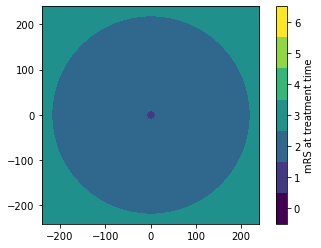

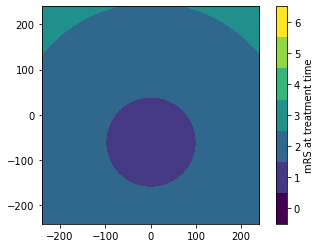

In [98]:
cmap = plt.get_cmap('viridis', 7)
for grid in [grid_mrs_patient1, grid_mrs_patient1a]:
    plt.imshow(grid, origin='lower', extent=extent,
               vmin=-0.5, vmax=6.5, cmap=cmap)
    plt.colorbar(label='mRS at treatment time')
    plt.show()

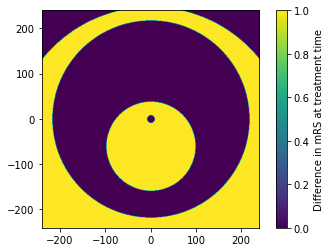

In [99]:
# cmap = plt.get_cmap('viridis', 7)
grid_mrs_diff = grid_mrs_patient1 - grid_mrs_patient1a
plt.imshow(grid_mrs_diff, origin='lower', extent=extent,
           # vmin=-0.5, vmax=6.5, 
           # cmap=cmap)
          )
plt.colorbar(label='Difference in mRS at treatment time')
plt.show()

Need fractional mRS for this to not be minging. 